In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage.measurements import label
from sklearn.cross_validation import train_test_split
%matplotlib inline

//anaconda/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### load data

In [2]:
images = glob.glob('*vehicles/*/*.png')
cars = []
notcars = []

for image in images:
    if 'non' in image:
        notcars.append(image)
    else:
        cars.append(image)
print(len(cars), len(notcars))

8792 8968


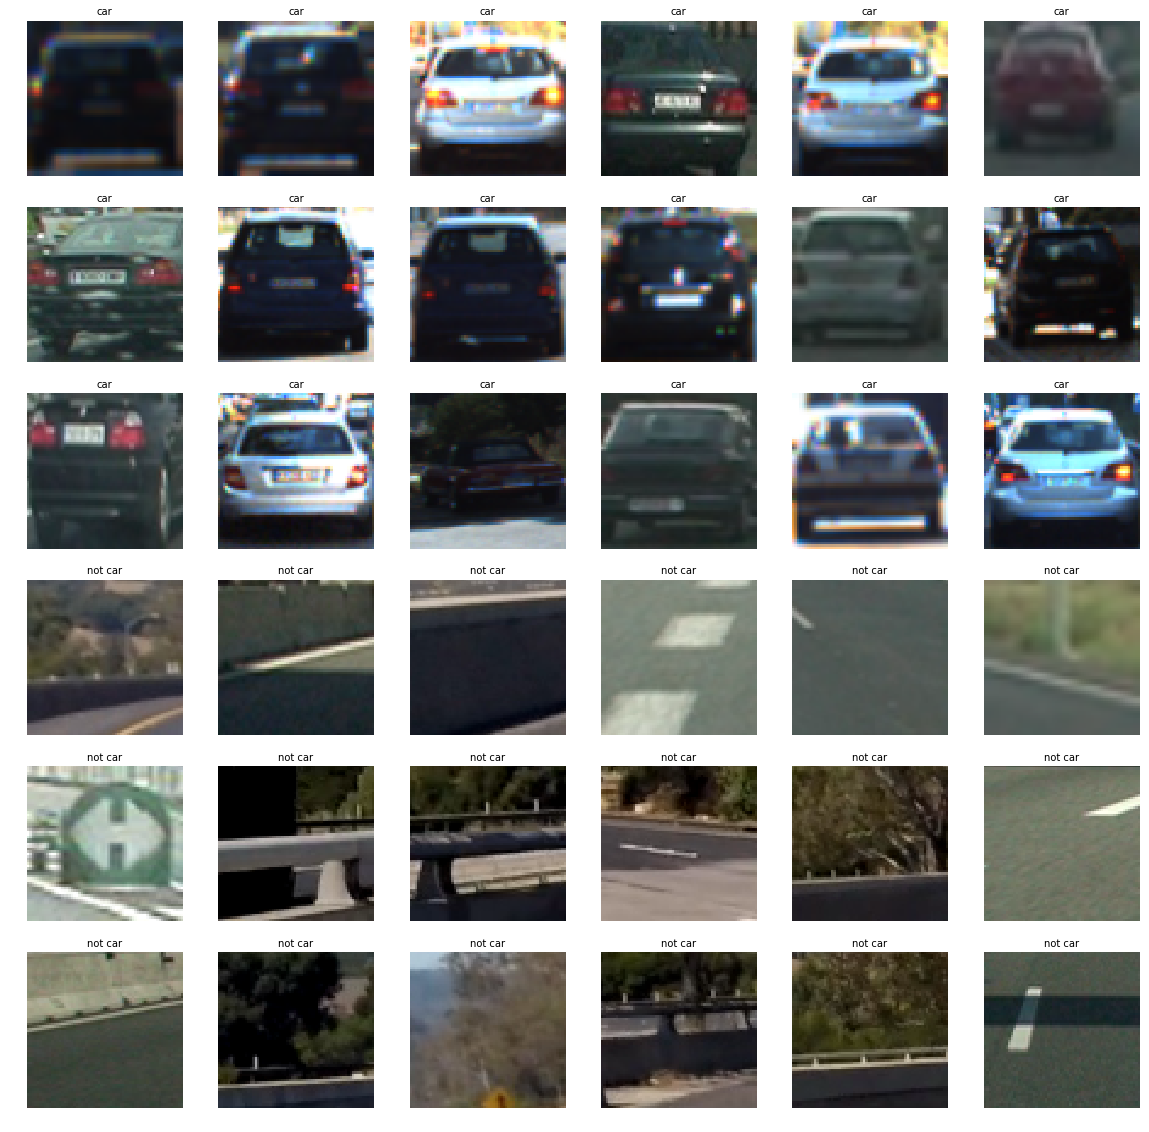

In [3]:
f, axs = plt.subplots(6, 6, figsize=(20,20))
axs = axs.ravel()

for i in range(18):
    img = cv2.imread(cars[np.random.randint(0, len(cars))])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=10)
    axs[i].imshow(img)
print('\n')
for i in range(18,36):
    img = cv2.imread(notcars[np.random.randint(0, len(notcars))])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('not car', fontsize=10)
    axs[i].imshow(img)
plt.savefig('./output_images/dataset_visualize'+'.jpg')

In [4]:

# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    test_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = test_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = test_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# # Plot the examples
# fig = plt.figure()
# plt.subplot(121)
# plt.imshow(car_image)
# plt.title('Example Car Image')
# plt.subplot(122)
# plt.imshow(notcar_image)
# plt.title('Example Not-car Image')


Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


### explore different color space

//anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


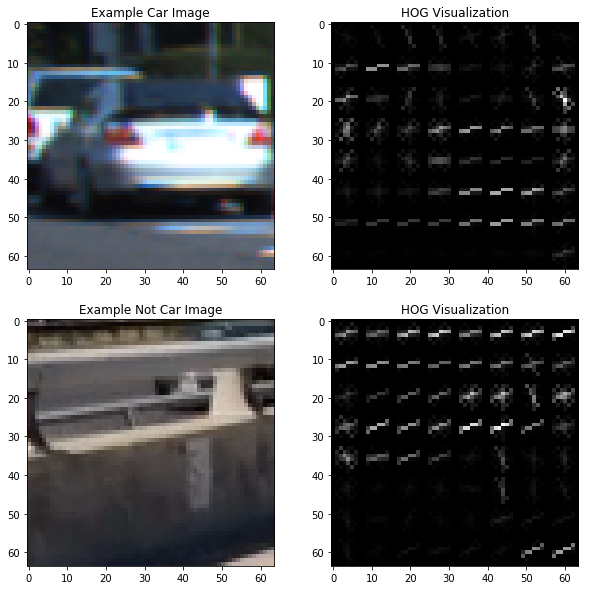

In [5]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        #features = [] # Remove this line
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features= hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=False, feature_vector=False)
        return features

# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
not_image = mpimg.imread(notcars[ind])
gray = cv2.cvtColor(not_image, cv2.COLOR_RGB2GRAY)
features, not_hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig,((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax1.imshow(image, cmap='gray')
ax1.set_title('Example Car Image')
ax2.imshow(hog_image, cmap='gray')
ax2.set_title('HOG Visualization')
ax3.imshow(not_image, cmap='gray')
ax3.set_title('Example Not Car Image')
ax4.imshow(not_hog_image, cmap='gray')
ax4.set_title('HOG Visualization')
plt.savefig('./output_images/dataset_hog_example'+'.jpg')

In [6]:
# Save the parameters for later use
dist_pickle = {}
# Define a key in data_dict "n_cars" and store the number of car images
dist_pickle["n_cars"] = len(cars)
# Define a key "n_notcars" and store the number of notcar images
dist_pickle["n_notcars"] = len(notcars)
# Read in a test image, either car or notcar
test_img = mpimg.imread(cars[0])
# Define a key "image_shape" and store the test image shape 3-tuple
dist_pickle["image_shape"] = test_img.shape
# Define a key "data_type" and store the data type of the test image.
dist_pickle["data_type"] = test_img.dtype


pickle.dump(dist_pickle, open("./data_pickle/data_dist_pickle.p", "wb"))


### define functions of combine features

In [7]:

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
print('Functions for extracting combined features done.')

Functions for extracting combined features done.


### extract features

In [8]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
visualize = True # Visualize hog image on or off
y_start_stop = [400, 656] # Min and max in y to search in slide_window()
scale = 1.5 # A parameter for the function finding cars

t = time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
 
t2 = time.time()

print(round(t2-t, 2), 'Seconds to extract Hog|bin spatial|histogram features...')

//anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


96.66 Seconds to extract Hog|bin spatial|histogram features...


### normalize features and split dataset

In [9]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
# Compute the mean and std to be used for later scaling.
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
# Perform standardization by centering and scaling
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

In [10]:

print('Parameters: \n',
    '\n feature vector length X_train: ', len(X_train[0]),
    '\n Scaled_X_train: ', len(scaled_X[0]),
    '\n Color Space: ',color_space,
    '\n orient: ',orient,
    '\n pixels per cell: ', pix_per_cell,
    '\n cells per block: ', cell_per_block,
    '\n hog_channel: ', hog_channel,
    '\n spatial_size: ', spatial_size,
    '\n hist_bins: ', hist_bins,
    '\n ystart: ', y_start_stop[0],
    '\n ystop: ', y_start_stop[1])


Parameters: 
 
 feature vector length X_train:  6156 
 Scaled_X_train:  6156 
 Color Space:  YCrCb 
 orient:  9 
 pixels per cell:  8 
 cells per block:  2 
 hog_channel:  ALL 
 spatial_size:  (16, 16) 
 hist_bins:  32 
 ystart:  400 
 ystop:  656


### Classify

In [11]:
### Classify
from sklearn import svm, grid_search
from sklearn.grid_search import GridSearchCV
# Use a linear SVC 
# Automatically tuning parameters

# # Check the training time for the SVC
# t=time.time()
# parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
# svr = svm.SVC()
# svc = grid_search.GridSearchCV(svr, parameters)
# svc.fit(X_train, y_train)
# t2 = time.time()

# Check the training time for the SVC
t=time.time()
svc = LinearSVC()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC using GridSearchCV')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

//anaconda/envs/carnd-term1/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


14.75 Seconds to train SVC using GridSearchCV
Test Accuracy of SVC =  0.9862
My SVC predicts:  [ 0.  0.  1.  1.  1.  0.  1.  1.  1.  0.]
For these 10 labels:  [ 0.  0.  1.  1.  1.  1.  1.  1.  1.  0.]
0.00314 Seconds to predict 10 labels with SVC


### sliding windows

In [12]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


In [13]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #print(spatial_features.shape)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #print(hist_features.shape)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True)) 
            hog_features = np.ravel(hog_features) 
    
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
    
    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    
    

### test sliding window 

//anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


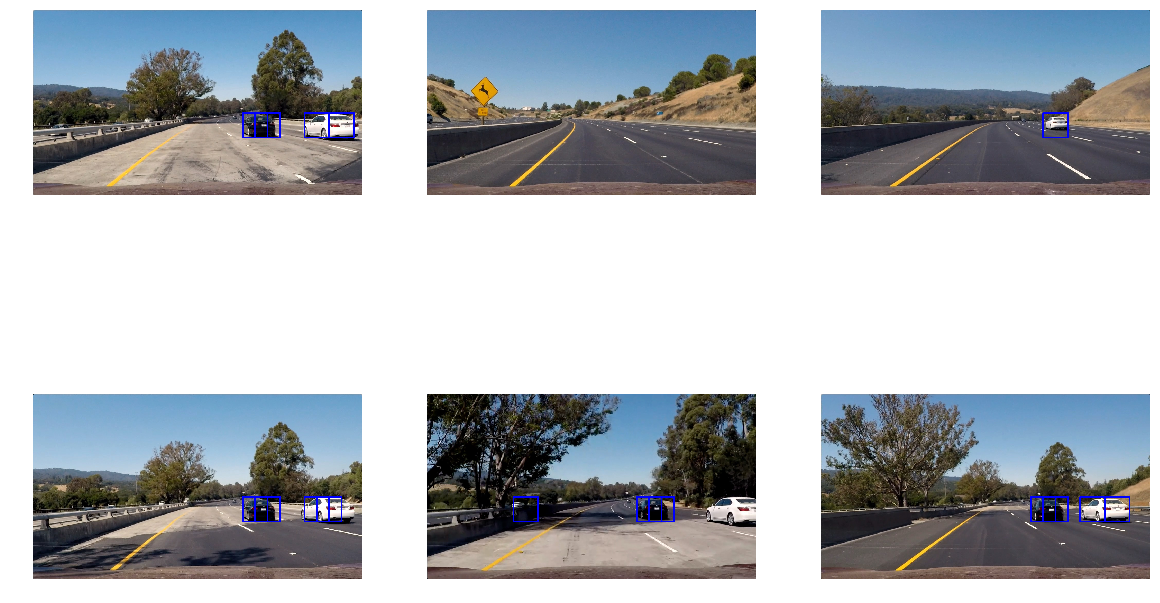

In [19]:
images = glob.glob('test_images/*.jpg')
window_list = []
y_start_stop = [400, 656]
for file_image in images:
    image=cv2.imread(file_image)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Equal to mpimg.imread(file_image)
    draw_image = np.copy(image)
    #image = draw_image.astype(np.float32)/255
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = draw_image.astype(np.float32)/255

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                                

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    #window_img=cv2.cvtColor(window_img, cv2.COLOR_BGR2RGB)
    window_list.append(window_img)
    #plt.imshow(window_img)

plt.figure(figsize=(20, 20))
for i in range(len(window_list)):
    plt.subplot(3,3,i+1)
    plt.axis('off')
    #axs[i].set_title('car', fontsize=10)
    plt.imshow(window_list[i])

plt.savefig('./output_images/sliding_window_example.jpg')

**You can see that for this method there are some false positive windows and some cars and not detected. we now try some efficient method. The mehod can both extract features and make predictions. It only has to extract hog features once and then can be sub-sampled to get all of its overlaying windows.**

### More efficient method for sliding window

In [20]:

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Define a single function that can extract features using hog sub-sampling and make predictions
# Both extract features and make predictions.
# It only has to extract hog features once and then can be sub-sampled to get all of its overlaying windows. 
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    # Normalize
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    if hog_channel == "ALL":
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    else:
        hogx = get_hog_features(ctrans_tosearch[:,:,hog_channel], orient, pix_per_cell, cell_per_block, feature_vec=False)
    # bbox
    box = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            if hog_channel == "ALL":
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hogx[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                box.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return draw_img, box
    

### test efficient sliding window 

//anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


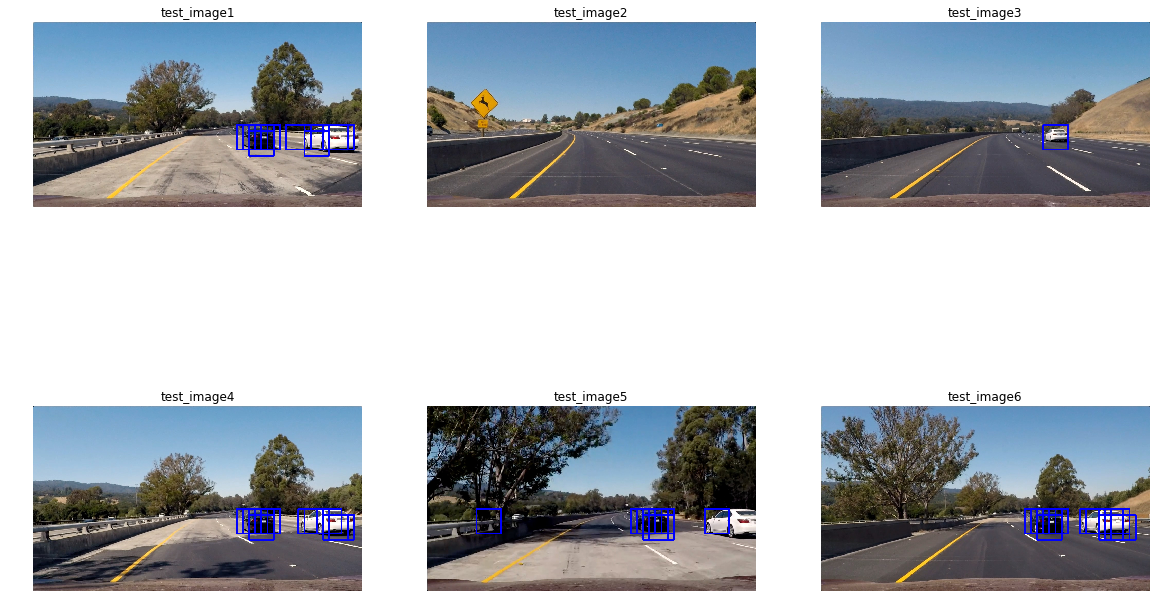

In [21]:
#y_start_stop = 400, 656
ystart, ystop = 400, 656

# It's possible to run this same function multiple times for different scale values 
# to generate multiple-scaled search windows.
scale = 1.5

images = glob.glob('test_images/*.jpg')
test_list = []
box_list = []
for file_image in images:
    image=cv2.imread(file_image)
    img=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    out_img, box = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    test_list.append(out_img)
    box_list.append(box)
    #plt.imshow(out_img)

plt.figure(figsize=(20, 20))
for i in range(len(test_list)):
    plt.subplot(3,3,i+1)
    plt.title('test_image'+str(i+1))
    plt.axis('off')
    #axs[i].set_title('car', fontsize=10)
    plt.imshow(test_list[i])

plt.savefig('./output_images/advanced_sliding_window_example.jpg')

//anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


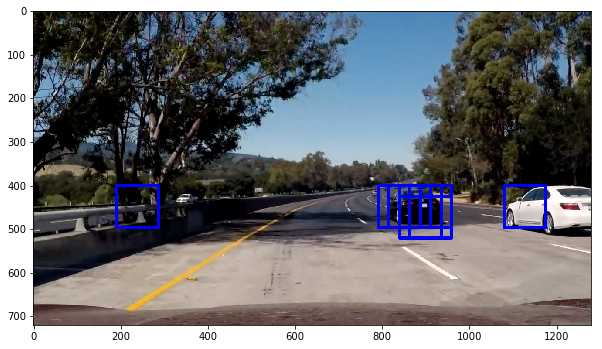

In [22]:
# Take an single image as an example
#scale = 1.5
single_img = mpimg.imread('test_images/test5.jpg')
single_out_img, single_boxs = find_cars(single_img, ystart, ystop, scale, svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, spatial_size, hist_bins)
plt.figure(figsize=(10,10))
plt.imshow(single_out_img)
plt.savefig('./output_images/sliding_window_example_test5.jpg')

### Multiple Detections & False Positives

**heat map**

In [24]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


cars found:  3


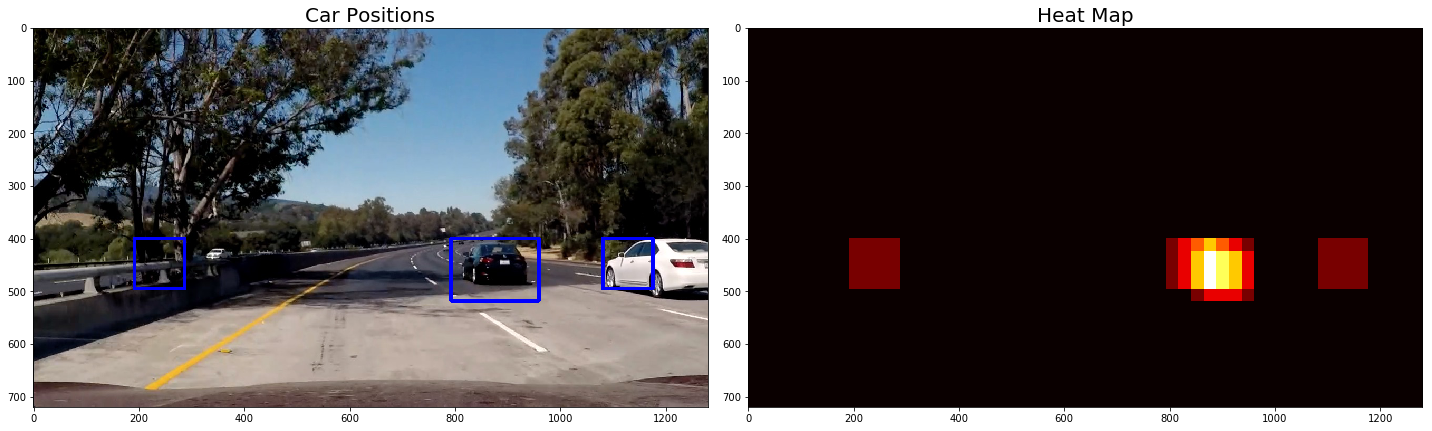

In [26]:
# Read in image similar to one shown above 
image = mpimg.imread('test_images/test5.jpg')

heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat, single_boxs)

# # Apply threshold to help remove false positives
# heat = apply_threshold(heat,3)


# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

print('cars found: ', labels[1])
fig = plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions', fontsize=20)
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map', fontsize=20)
fig.tight_layout()
plt.savefig('./output_images/heat_map_no_thresh_test5.jpg')

apply threshold:  1
cars found:  1


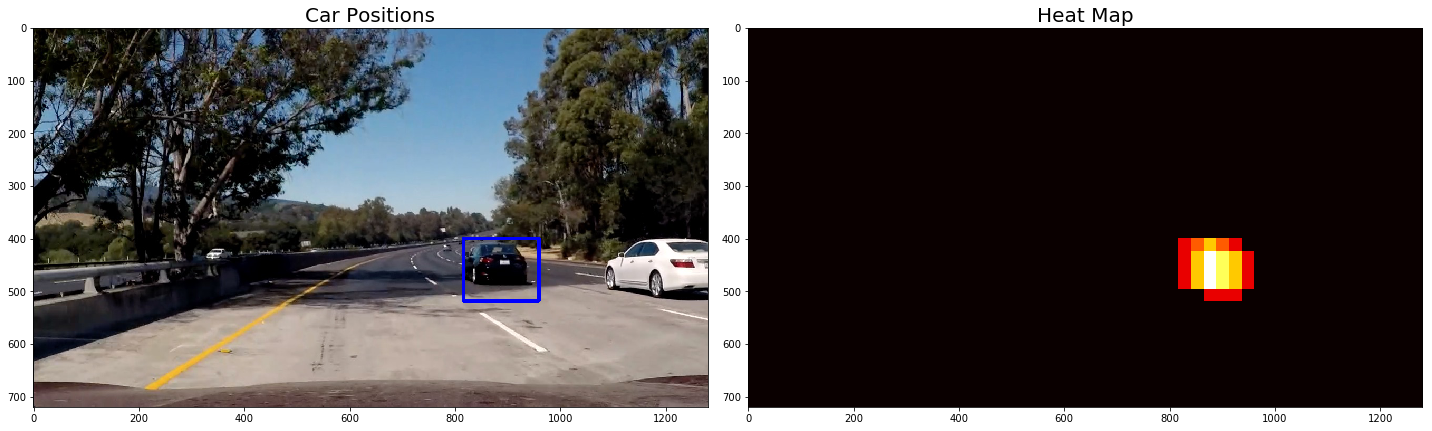

In [27]:
# Read in image similar to one shown above 
thresh = 1
print('apply threshold: ', thresh)
image = mpimg.imread('test_images/test5.jpg')

heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat, single_boxs)

# Apply threshold to help remove false positives
heat = apply_threshold(heat,thresh)


# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

print('cars found: ', labels[1])
fig = plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions', fontsize=20)
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map', fontsize=20)
fig.tight_layout()
plt.savefig('./output_images/heat_map_with_thresh_test5.jpg')

In [28]:
def process_image(image):
    '''process each single image'''
    
    ystart, ystop = 400, 656
    thresh = 1
    scale = 1.5
    
    # Converts color
    img=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    draw_image = np.copy(img)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Finding car positions
    # Note normalization function has been writen in the find_cars
    _, single_boxs = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    # Add heat to each box in box list
    heat = add_heat(heat, single_boxs)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, thresh)

    # Find final boxes from heatmap using label function
    labels = label(heat)
    draw_img = draw_labeled_bboxes(draw_image, labels)
    
    return draw_img

//anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


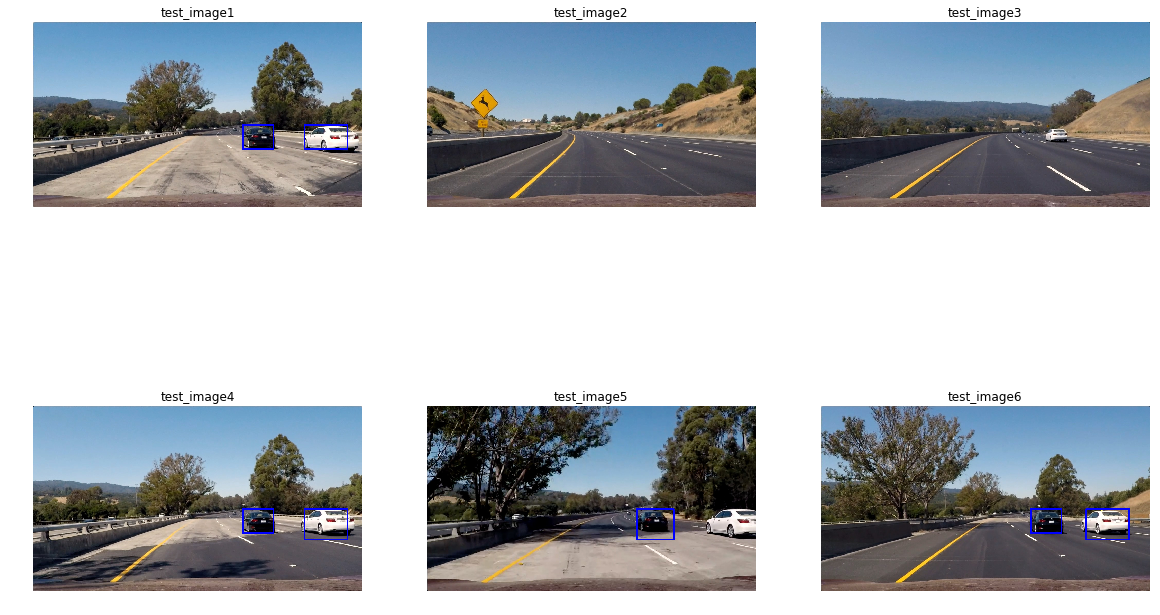

In [29]:
#y_start_stop = 400, 656
ystart, ystop = 400, 656

# It's possible to run this same function multiple times for different scale values 
# to generate multiple-scaled search windows.
scale = 1.5

images = glob.glob('test_images/*.jpg')
test_list = []
box_list = []
for file_image in images:
    image=cv2.imread(file_image)
    #img=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #image = image.astype(np.float32)/255
    
    draw_img = process_image(image)
    
    test_list.append(draw_img)
    box_list.append(box)
    #plt.imshow(out_img)

plt.figure(figsize=(20, 20))
for i in range(len(test_list)):
    plt.subplot(3,3,i+1)
    plt.title('test_image'+str(i+1))
    plt.axis('off')
    #axs[i].set_title('car', fontsize=10)
    plt.imshow(test_list[i])
plt.savefig('./output_images/heat_map_with_thresh_examples.jpg')

### define class

In [30]:
# Define a class to receive the characteristics of each vehicle detection
class Detection():
    def __init__(self, n):
        # How many frames to use to smooth
        self.n = n
        
        # Line smoothing
        self.windows = []
             
    def add_to_smooth_detect(self, window):
        '''Smoothing over the last n frames'''
        
        self.windows.append(window)
        
        
        # Keep size of windows equal to n
        if len(self.windows)>self.n:
            self.windows.pop(0)
        
        #self.ave_A = np.mean(self.A)
        
        return self.windows 
    
    def get_results_of_smooth_detect(self):
        return self.windows

### process each frame with smoothing

In [34]:
def process_each_frame(image):
    '''process each frame of the video'''
    
#     ystart, ystop = 400, 656
#     thresh = 1
#     scale = 1.5
    
    # Converts color
    #img=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    draw_image = np.copy(image)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Finding car positions
    # Note normalization function has been writen in the find_cars
    _, single_boxs = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    # Smooth frames
    if len(single_boxs)>0:
        detection.add_to_smooth_detect(single_boxs)
    
    # Return previous windows
    previous_windows = detection.get_results_of_smooth_detect()
    
    # Add heat to each box in box list
    for window in previous_windows:
        heat = add_heat(heat, window)
    #print(len(previous_windows))
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1+len(previous_windows)//2)

    # Find final boxes from heatmap using label function
    labels = label(heat)
    draw_img = draw_labeled_bboxes(draw_image, labels)
    
    return draw_img
    

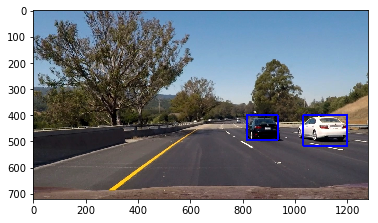

In [60]:
ystart, ystop = 400, 656
#thresh = 1
scale = 1.5
frames = 10
detection = Detection(n=frames)

img = mpimg.imread('test_images/test6.jpg')
draw_img = process_each_frame(img)
plt.imshow(draw_img)
plt.savefig('./output_images/final_example_test5.jpg')

### output video

In [38]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

ystart, ystop = 400, 656
#thresh = 1
scale = 1.5
frames = 10
detection = Detection(n=frames)

test_out_file = 'project_video_result.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(process_each_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


100%|█████████▉| 1260/1261 [08:48<00:00,  2.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

CPU times: user 14min 18s, sys: 36 s, total: 14min 54s
Wall time: 8min 49s


### Combine with detecing lines

In [66]:
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pickle
from Line_class import Line
from combined_thresh import combined_thresh
from Perspective_transform import perspective_transorm
from polynomial_fit import line_fit, advanced_fit, line_fit_visualize, advanced_fit_visualize
% matplotlib inline

def calculate_curvature(leftx, rightx, lefty, righty):
    '''Calculate the radius of curvature in meters'''
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    #y_eval = np.max(ploty)
    y_eval = 719
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    
    return left_curverad, right_curverad

def calculate_offset(undist, left_fit, right_fit):
    '''Calculate the offset of the lane center from the center of the image'''
    
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    ploty = undist.shape[0] # height
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    offset = (left_fitx+right_fitx)/2 - undist.shape[1]/2 # width 
    offset = xm_per_pix*offset
    
    return offset

def final_drawing(undist, left_fit, right_fit, left_curverad, right_curverad, Minv, vehicle_offset):
    '''Project the measurement back down onto the original undistorted image of the road'''
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, undist.shape[0]-1, undist.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warped = np.zeros((720,1280))
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # Anotate curvature values 
    ave_curvature = (left_curverad + right_curverad)/2
    ave_text = 'Radius of average curvature: %.2f m'%ave_curvature
    cv2.putText(result, ave_text,(50,50), 0, 1, (0,0,0), 2, cv2.LINE_AA)
    
    # Anotate vehicle offset from the lane center
    if(vehicle_offset>0):
        offset_text = 'Vehicle right offset from lane center: {:.2f} m'.format(vehicle_offset)
    else:
        offset_text = 'Vehicle left offset from the lane center: {:.2f} m'.format(-vehicle_offset)
    cv2.putText(result, offset_text,(50,80), 0, 1, (0,0,0), 2, cv2.LINE_AA)
    
    #plt.imshow(result)
    
    return result

def process_video_image(img):
    '''Process each image in the video and return with annotated image'''
    
    global detected, mtx, dist, left_lanes, right_lanes
    # Undistorting image
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    # Combined thresh
    combined = combined_thresh(undist)

    # Warped image
    binary_warped, _, Minv = perspective_transorm(combined)

    # Line fit
    if not detected:
        curv_pickle = line_fit(binary_warped)
        
        if curv_pickle is not None:
            left_fit = curv_pickle["left_fit"]
            right_fit = curv_pickle["right_fit"]
            leftx = curv_pickle["leftx"]
            lefty = curv_pickle["lefty"]
            rightx = curv_pickle["rightx"]
            righty = curv_pickle["righty"]

            # Update
            # Add into the set to smoothing average fit
            left_fit = left_lanes.add_to_smooth_fit(left_fit)
            right_fit = right_lanes.add_to_smooth_fit(right_fit)

            # Calculate curvature
            # Assume first frame can be detected both lanes and curvatures 
            left_curvature, right_curvature = calculate_curvature(leftx, rightx, lefty, righty)

#             # Add into the set to smoothing average curvature
#             # Only use for a frame without detected lanes
#             special_left_curv = left_lanes.ave_curvature(left_curvature)
#             special_right_curv = right_lanes.ave_curvature(right_curvature)

            detected = True
        else:
            # Calculate based on previous frames
            left_fit = left_lanes.get_results_of_smooth_fit()
            right_fit = right_lanes.get_results_of_smooth_fit()
            special_left_curv = left_lanes.get_results_of_ave_curvature()
            special_right_curv = right_lanes.get_results_of_ave_curvature()
            left_curvature, right_curvature = special_left_curv, special_right_curv
            detected = False
    else:
        # Smooth fit
        left_fit = left_lanes.get_results_of_smooth_fit()
        right_fit = right_lanes.get_results_of_smooth_fit()
        
        # Add into the set to smoothing average curvature
        # Only use for a frame without detected lanes
        special_left_curv = left_lanes.get_results_of_ave_curvature()
        special_right_curv = right_lanes.get_results_of_ave_curvature()
        
        # Skip the sliding windows step once you know where the lines are
        # Search in a margin around the previous line position 
        curv_pickle = advanced_fit(binary_warped, left_fit, right_fit)
        
        if curv_pickle is not None:
            # Detected lines 
            left_fit = curv_pickle["left_fit"]
            right_fit = curv_pickle["right_fit"]
            leftx = curv_pickle["leftx"]
            lefty = curv_pickle["lefty"]
            rightx = curv_pickle["rightx"]
            righty = curv_pickle["righty"]
            
            # Note: We only make update when detect lanes in the current frame
            # Add into the set to smoothing average fit
            left_fit = left_lanes.add_to_smooth_fit(left_fit)
            right_fit = right_lanes.add_to_smooth_fit(right_fit)
            
            # Calculate curvature
            left_curvature, right_curvature = calculate_curvature(leftx, rightx, lefty, righty)
        else:
            # Calculate curvature based on previous frames
            left_curvature, right_curvature = special_left_curv, special_right_curv
            detected = False
            
        
    # Calculate vehicle offset from the lane center in the image
    vehicle_offset = calculate_offset(undist, left_fit, right_fit)
    if vehicle_offset > 0.25:
        detected = False
    
    # Project the measurement back down onto the original undistorted image of the road
    result = final_drawing(undist, left_fit, right_fit, left_curvature, right_curvature, Minv, vehicle_offset)
    
    return result

def final_process_image(img):
    result = process_video_image(img)
    return process_each_frame(result)

if __name__ == '__main__':

    # Read in the saved camera matrix and distortion coefficients
    dist_pickle = pickle.load(open("./camera_cal/camera_dist_pickle.p", "rb"))
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

     # Define number of frames for smoothing
    num_frames = 5
    left_lanes = Line(n=num_frames) 
    right_lanes = Line(n=num_frames)
    detected = False 

    img = mpimg.imread('./test_images/test6.jpg')
    #result = process_video_image(img)
    result = final_process_image(img)
    
    plt.imshow(result)
    plt.savefig('./output_images/final_combined_example_test6.jpg')
#     mpimg.imsave('./output_img/test2_final_projected.jpg', result)

#     # Visualize images
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#     f.tight_layout()
#     ax1.imshow(img)
#     ax1.set_title('Original Image', fontsize=50)
#     ax2.imshow(result)
#     ax2.set_title('Polynomial Fit Image', fontsize=50)
#     plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#     plt.savefig('./output_img/test2_final_projected_example.jpg')   

#     # Import everything needed to edit/save/watch video clips
#     from moviepy.editor import VideoFileClip
#     from IPython.display import HTML

    # Define number of frames for smoothing
    num_frames = 8
    left_lanes = Line(n=num_frames) 
    right_lanes = Line(n=num_frames)
    detected = False 
   
    ystart, ystop = 400, 656
    #thresh = 1
    scale = 1.5
    frames = 10
    detection = Detection(n=frames)

    white_output = 'test_demo.mp4'
    clip1 = VideoFileClip("project_video.mp4")
    white_clip = clip1.fl_image(final_process_image) #NOTE: this function expects color images!!
    #%time white_clip.write_videofile(white_output, audio=False)
    white_clip.write_videofile(white_output, audio=False)    


[MoviePy] >>>> Building video test_demo.mp4
[MoviePy] Writing video test_demo.mp4


100%|█████████▉| 1260/1261 [16:33<00:00,  1.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_demo.mp4 



In [70]:
ystart, ystop = 400, 656
#thresh = 1
scale = 1.3
frames = 10
detection = Detection(n=frames)

white_output = 'test_demo——s.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(final_process_image) #NOTE: this function expects color images!!
#%time white_clip.write_videofile(white_output, audio=False)
white_clip.write_videofile(white_output, audio=False)    


[MoviePy] >>>> Building video test_demo——s.mp4
[MoviePy] Writing video test_demo——s.mp4


 97%|█████████▋| 38/39 [00:32<00:00,  1.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_demo——s.mp4 



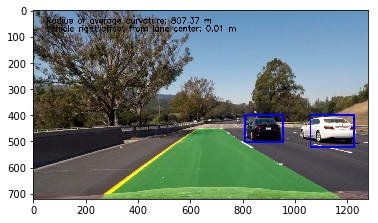

In [73]:
# Define number of frames for smoothing
num_frames = 5
left_lanes = Line(n=num_frames) 
right_lanes = Line(n=num_frames)
detected = False 

img = mpimg.imread('./test_images/test6.jpg')
#result = process_video_image(img)
result = final_process_image(img)
    
plt.imshow(result)
plt.savefig('./output_images/final_combined_example_test6.jpg')